### Generate some statistics files

In [1]:
! pip install libsumo addict

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import analysis.stats_utils as stats_utils
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/"
mode="ITE_autoware_universe_map_recalibrate_v6"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [3]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 19423/19423 [01:24<00:00, 228.79it/s]

info_error:  0


0

In [4]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [6]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v6_481_1,1382.0,1082,300,NaN,NaN,-0.061613,491,NaN,-1.0,NaN,NaN,54460.678832,2944.495810,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
2,ITE_autoware_universe_map_recalibrate_v6_481_3,1272.0,972,300,NaN,NaN,-0.147445,1801,NaN,-1.0,NaN,NaN,65145.572054,2173.005099,NaN,NaN,NaN,None,-10.000000,NaN
3,ITE_autoware_universe_map_recalibrate_v6_481_4,1338.0,1038,300,NaN,NaN,-0.092289,768,NaN,-1.0,NaN,NaN,57927.857197,1426.481520,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v6_481_5,1427.0,1127,300,NaN,NaN,-0.098064,912,NaN,-1.0,NaN,NaN,57357.766912,3850.465223,NaN,NaN,NaN,None,-10.000000,NaN


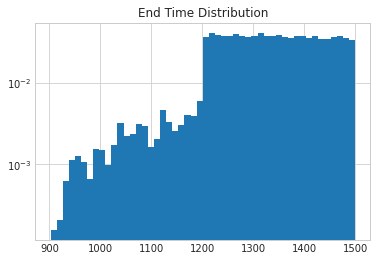

In [7]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [8]:
warm_up_time = exp_stats_info["warmup_time"]
estimated_end_time = exp_stats_info["warmup_time"] + exp_stats_info["run_time"]

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 2166 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [9]:
collision_df.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
11,ITE_autoware_universe_map_recalibrate_v6_481_12,1434.4,1180,300,BV_23.42,BV_2.47,3.222623,354,BV_2.47,2.4,Lead,intersection_rearend,42768.207233,2474.939290,EG_25_2_1_0,rear_end,intersection,0.0,-0.059547,4.570012
14,ITE_autoware_universe_map_recalibrate_v6_481_15,1355.3,1106,300,BV_17.50,BV_17.53,3.233098,628,BV_17.50,0.6,RightFoll,highway_cutin,36639.340623,2125.261864,EG_1_1_1_0,sideswipe,freeway_2,19.77917622027556,-0.867177,2.271986
24,ITE_autoware_universe_map_recalibrate_v6_481_25,1322.9,1092,300,BV_13.17,BV_7.11,2.785350,1193,BV_13.17,0.6,LeftFoll,intersection_cutin,52525.155213,4259.122036,EG_8_23_12_1,sideswipe,intersection,13.671115993659782,-3.211012,1.252679
36,ITE_autoware_universe_map_recalibrate_v6_49_2,1001.0,997,300,BV_22.7,BV_17.39,3.297920,37,BV_22.7,0.7,LeftFoll,roundabout_cutin,793.730432,21.062946,EG_34_1_24_1,angle,roundabout,37.04973703328128,-0.109762,3.218092


In [10]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - exp_stats_info["warmup_time"]).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 19423
Number of collision: 2166
Collisions with weight less than 1: 2022
Importance summation: 1.9768718553923132
Max weight: 0.0180721921193669, Min weight: 1.567633158714736e-10
raw collision rate: 0.11151727333573598
adjusted collision rate (importance): 0.000101779944158591
Collision due to traffic light ignorance: 97
Overall maneuvers: 17065795
Collision without negligence: 156
Maximum time between collision and negligence: 4.30 s

Overall time: 5494286.50 s
Maneuvers per second: 3.106098489767507
Overall route length: 1088670602.72 m
m/s: 198.14594719752083
Overall route length: 676468.5503640312 mile
mile/s: 0.12312218344711934 mile/s
Crash per mile: 2.9223411115394644e-06 crash/mile


In [11]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v6_481_1,1382.0,1082,300,NaN,NaN,-0.061613,491,NaN,-1.0,NaN,NaN,54460.678832,2944.495810,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
2,ITE_autoware_universe_map_recalibrate_v6_481_3,1272.0,972,300,NaN,NaN,-0.147445,1801,NaN,-1.0,NaN,NaN,65145.572054,2173.005099,NaN,NaN,NaN,None,-10.000000,NaN
3,ITE_autoware_universe_map_recalibrate_v6_481_4,1338.0,1038,300,NaN,NaN,-0.092289,768,NaN,-1.0,NaN,NaN,57927.857197,1426.481520,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v6_481_5,1427.0,1127,300,NaN,NaN,-0.098064,912,NaN,-1.0,NaN,NaN,57357.766912,3850.465223,NaN,NaN,NaN,None,-10.000000,NaN


In [12]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < exp_stats_info["warmup_time"] + exp_stats_info["run_time"])]
a

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
58,ITE_autoware_universe_map_recalibrate_v6_49_24,1045.9,1007,300,BV_17.54,BV_8.63,-0.034856,272,BV_8.63,-1.0,NaN,NaN,10724.719414,488.050336,:nd_34_1_6_1_0,sideswipe,roundabout_1,15.537037957225209,3.28,1.427962
192,ITE_autoware_universe_map_recalibrate_v6_448_34,1112.9,1053,300,BV_22.11,BV_21.57,-0.039710,374,BV_21.57,-1.0,NaN,NaN,14704.273682,837.786958,:nd_34_1_6_0_0,angle,roundabout_1,20.844460748422648,3.28,2.694315
218,ITE_autoware_universe_map_recalibrate_v6_192_21,1232.5,1050,300,BV_1.15,BV_3.9,-0.034168,386,BV_3.9,-1.0,NaN,NaN,37202.058331,3206.795962,:NODE_11_16_0,head_on,intersection,122.18457805622393,-1.00,7.518289
344,ITE_autoware_universe_map_recalibrate_v6_48_33,1425.2,1183,300,BV_16.28,BV_7.16,-0.139142,987,BV_7.16,-1.0,NaN,NaN,51048.196829,3387.424386,:NODE_18_10_0,angle,intersection,119.31732568991697,3.28,5.086504
637,ITE_autoware_universe_map_recalibrate_v6_414_7,999.7,997,300,BV_16.19,BV_7.8,-0.000393,6,BV_7.8,-1.0,NaN,NaN,501.730383,0.529897,:NODE_18_10_0,angle,intersection,122.73178855870003,3.28,4.558844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18978,ITE_autoware_universe_map_recalibrate_v6_38_36,1424.8,1129,300,BV_16.24,BV_13.14,-0.194158,1619,BV_13.14,-1.0,NaN,NaN,65843.778577,4535.027418,:NODE_18_10_0,angle,intersection,119.3517434576982,3.28,5.678260
19030,ITE_autoware_universe_map_recalibrate_v6_156_8,1085.1,955,300,BV_8.49,BV_17.39,-0.045898,392,BV_17.39,-1.0,NaN,NaN,25189.511879,1536.107077,:nd_34_1_6_0_0,sideswipe,roundabout_1,13.71732610691862,3.28,1.204372
19179,ITE_autoware_universe_map_recalibrate_v6_242_43,1160.4,1101,300,BV_1.12,BV_22.12,-0.030372,170,BV_22.12,-1.0,NaN,NaN,12863.077041,697.254994,:NODE_18_8_0,angle,intersection,129.72994837194153,-1.00,10.022224
19257,ITE_autoware_universe_map_recalibrate_v6_379_1,1338.6,1126,300,BV_16.16,BV_13.13,-0.048815,351,BV_13.13,-1.0,NaN,NaN,42957.688850,1084.998262,:NODE_18_10_0,angle,intersection,119.35047954392985,3.28,5.239925


#### BV_22 Collision

In [13]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 189
Total bv_22 distance: 56356424.37382355
Number of bv_22 collision importance > 1: 16
Raw collision rate: 0.009730731606857848
Collision rate: 9.665134791580199e-06
Collision rate (weighted): 5.360800923397645e-06


### Crash Distribution (with negligence)

In [14]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [15]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v6_481_1,1382.0,1082,300,NaN,NaN,-0.061613,491,NaN,-1.0,NaN,NaN,54460.678832,2944.495810,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
2,ITE_autoware_universe_map_recalibrate_v6_481_3,1272.0,972,300,NaN,NaN,-0.147445,1801,NaN,-1.0,NaN,NaN,65145.572054,2173.005099,NaN,NaN,NaN,None,-10.000000,NaN
3,ITE_autoware_universe_map_recalibrate_v6_481_4,1338.0,1038,300,NaN,NaN,-0.092289,768,NaN,-1.0,NaN,NaN,57927.857197,1426.481520,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v6_481_5,1427.0,1127,300,NaN,NaN,-0.098064,912,NaN,-1.0,NaN,NaN,57357.766912,3850.465223,NaN,NaN,NaN,None,-10.000000,NaN


In [16]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

2012 156


Negligence caused distribution

In [17]:
neg_caused_collision["lane_id"].value_counts()

EG_25_2_1_0     216
EG_1_3_1_1      144
EG_1_3_1_0      125
EG_16_23_1_1    124
EG_13_1_1_0      97
               ... 
gneE0_0           1
:NODE_10_1_0      1
:NODE_20_3_0      1
:NODE_16_1_0      1
:NODE_11_4_0      1
Name: lane_id, Length: 106, dtype: int64

No negligence caused distribution

In [18]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_18_10_0     88
:nd_34_1_6_0_0    20
:NODE_11_15_0     11
:NODE_18_8_0      10
EG_18_12_171_1     8
:nd_34_1_6_1_0     7
EG_16_45_1_1       4
:NODE_11_16_0      3
:NODE_18_17_0      2
:NODE_6_2_0        1
:NODE_24_3_0       1
gneE8_0            1
Name: lane_id, dtype: int64
156


### Crash Distribution (with negligence)

In [19]:
neg_caused_collision.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
11,ITE_autoware_universe_map_recalibrate_v6_481_12,1434.4,1180,300,BV_23.42,BV_2.47,3.222623,354,BV_2.47,2.4,Lead,intersection_rearend,42768.207233,2474.939290,EG_25_2_1_0,rear_end,intersection,0.0,-0.059547,4.570012
14,ITE_autoware_universe_map_recalibrate_v6_481_15,1355.3,1106,300,BV_17.50,BV_17.53,3.233098,628,BV_17.50,0.6,RightFoll,highway_cutin,36639.340623,2125.261864,EG_1_1_1_0,sideswipe,freeway_2,19.77917622027556,-0.867177,2.271986
24,ITE_autoware_universe_map_recalibrate_v6_481_25,1322.9,1092,300,BV_13.17,BV_7.11,2.785350,1193,BV_13.17,0.6,LeftFoll,intersection_cutin,52525.155213,4259.122036,EG_8_23_12_1,sideswipe,intersection,13.671115993659782,-3.211012,1.252679
36,ITE_autoware_universe_map_recalibrate_v6_49_2,1001.0,997,300,BV_22.7,BV_17.39,3.297920,37,BV_22.7,0.7,LeftFoll,roundabout_cutin,793.730432,21.062946,EG_34_1_24_1,angle,roundabout,37.04973703328128,-0.109762,3.218092


In [20]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [21]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_574389/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,19,0.010655,0.000978,5.485812e-07
1,freeway,rear,37,0.277477,0.001905,1.428602e-05
2,freeway,sideswipe,271,0.147613,0.013953,7.599922e-06
3,intersection,angle,224,0.546676,0.011533,2.814583e-05
4,intersection,head,134,0.106349,0.006899,5.475404e-06
5,intersection,rear,980,0.552194,0.050456,2.842989e-05
6,intersection,sideswipe,165,0.219046,0.008495,1.127768e-05
7,roundabout,angle,104,0.056543,0.005354,2.911135e-06
8,roundabout,rear,37,0.020554,0.001905,1.058206e-06
9,roundabout,sideswipe,41,0.022731,0.002111,1.170313e-06


location
freeway         0.220422
intersection    0.720464
roundabout      0.050498
Name: exp_importance, dtype: float64


Text(0.5, 1.0, 'ground truth')

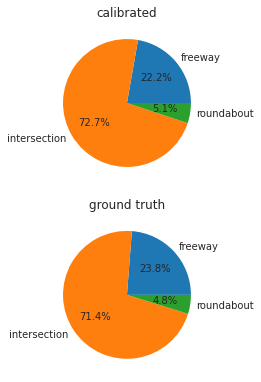

In [22]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

In [23]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

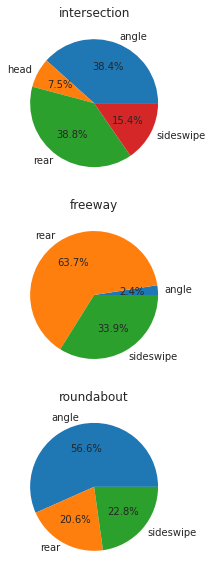

In [24]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [25]:
len(neg_caused_collision)

2012

#### Negligence reason

In [26]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,33,0.273692,0.001699,0.000014
1,freeway,LeftFoll,156,0.086115,0.008032,0.000004
2,freeway,RightFoll,138,0.075938,0.007105,0.000004
3,intersection,Lead,1136,0.597402,0.058487,0.000031
4,intersection,LeftFoll,186,0.245570,0.009576,0.000013
5,intersection,RightFoll,84,0.110036,0.004325,0.000006
6,intersection,TFL,97,0.471258,0.004994,0.000024
7,roundabout,Lead,39,0.021365,0.002008,0.000001
8,roundabout,LeftFoll,56,0.031943,0.002883,0.000002
9,roundabout,RightFoll,87,0.046519,0.004479,0.000002


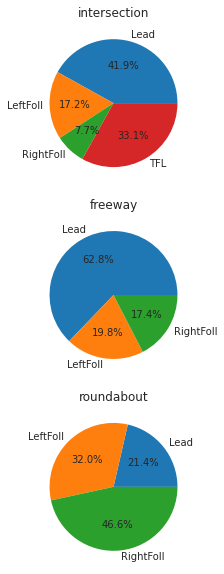

In [27]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [28]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,2,0.001124,0.000103,5.788467e-08
1,freeway,rear,2,0.020023,0.000103,1.030905e-06
2,freeway,sideswipe,28,0.014442,0.001442,7.435397e-07
3,intersection,angle,26,0.051025,0.001339,2.627023e-06
4,intersection,head,1,0.000586,0.000051,3.015663e-08
5,intersection,rear,54,0.036362,0.002780,1.872100e-06
6,intersection,sideswipe,40,0.052249,0.002059,2.690037e-06
7,roundabout,angle,12,0.006722,0.000618,3.461087e-07
8,roundabout,rear,6,0.003340,0.000309,1.719788e-07
9,roundabout,sideswipe,2,0.001267,0.000103,6.524675e-08


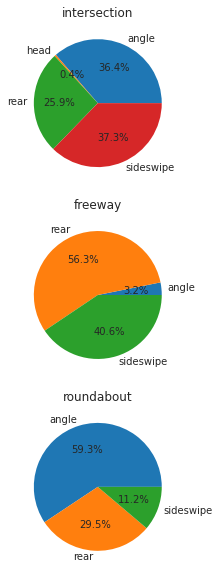

In [29]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [30]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

290


In [31]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
6427,ITE_autoware_universe_map_recalibrate_v6_73_32,1238.2,986,300,BV_13.11,BV_21.54,3.137638,967,BV_13.11,0.6,...,EG_1_1_1_1,sideswipe,freeway_2,16.03061175944046,-2.629385,2.330770,0.000728,freeway,sideswipe,0.004602
3971,ITE_autoware_universe_map_recalibrate_v6_83_40,1355.6,1085,300,BV_21.72,BV_14.14,3.214437,787,BV_21.72,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.632545941794532,-0.033913,3.407853,0.000610,freeway,sideswipe,0.008459
17178,ITE_autoware_universe_map_recalibrate_v6_236_37,1117.5,1088,300,BV_21.54,BV_8.60,3.293342,127,BV_21.54,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.75468625029481,-0.021502,3.038278,0.000509,freeway,sideswipe,0.011674
11142,ITE_autoware_universe_map_recalibrate_v6_3_24,1112.7,1045,300,BV_13.13,BV_21.47,3.270882,293,BV_13.13,0.6,...,EG_1_1_1_1,sideswipe,freeway_2,16.793737228628203,-0.236785,3.444133,0.000536,freeway,sideswipe,0.015060
105,ITE_autoware_universe_map_recalibrate_v6_219_25,1390.9,1176,300,BV_21.71,BV_17.75,3.193048,1044,BV_21.71,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.999401526066677,-0.152143,3.895329,0.000641,freeway,sideswipe,0.019111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17977,ITE_autoware_universe_map_recalibrate_v6_434_3,1068.8,961,300,BV_8.51,BV_21.57,3.269122,348,BV_8.51,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.761793371893816,-1.461647,2.580259,0.000538,freeway,sideswipe,0.900031
14,ITE_autoware_universe_map_recalibrate_v6_481_15,1355.3,1106,300,BV_17.50,BV_17.53,3.233098,628,BV_17.50,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,19.77917622027556,-0.867177,2.271986,0.000585,freeway,sideswipe,0.903725
2195,ITE_autoware_universe_map_recalibrate_v6_352_7,1331.7,1188,300,BV_17.80,BV_14.9,3.272545,263,BV_17.80,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.79206378475932,-1.167608,2.053321,0.000534,freeway,sideswipe,0.907098
7356,ITE_autoware_universe_map_recalibrate_v6_32_34,1260.1,1160,300,BV_8.70,BV_17.73,3.207575,367,BV_8.70,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.820469069939918,-0.489330,1.908310,0.000620,freeway,sideswipe,0.911016


0.06551724137931035


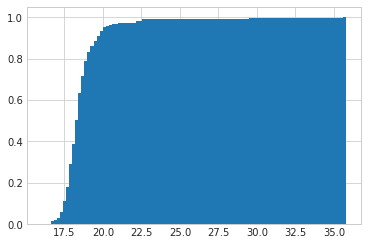

In [32]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

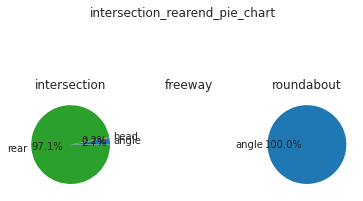

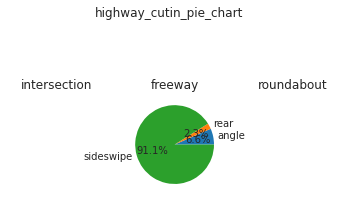

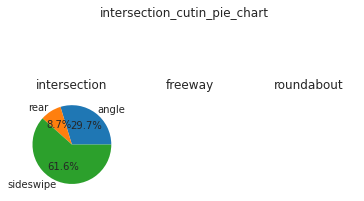

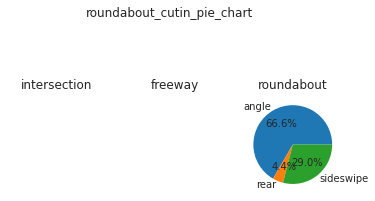

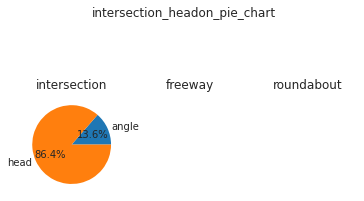

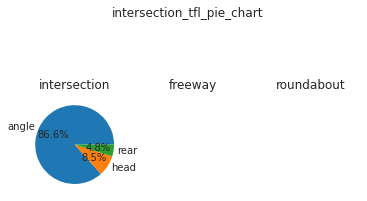

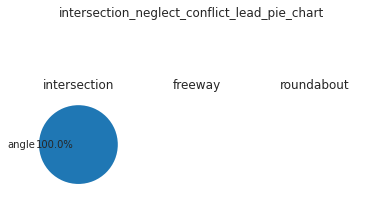

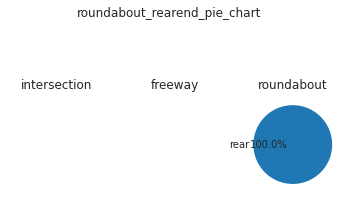

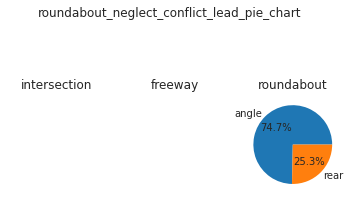

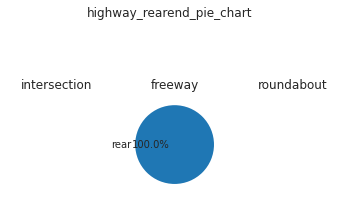

In [33]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [34]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,24,0.013956,0.001236,7.185350e-07
1,intersection,head,2,0.001160,0.000103,5.972409e-08
2,intersection,rear,950,0.498671,0.048911,2.567427e-05
3,roundabout,angle,1,0.000763,0.000051,3.928691e-08


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,19,0.010655,0.000978,5.485812e-07
1,freeway,rear,4,0.003786,0.000206,1.949013e-07
2,freeway,sideswipe,271,0.147613,0.013953,7.599922e-06


intersection_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,79,0.105566,0.004067,0.000005
1,intersection,rear,26,0.030994,0.001339,0.000002
2,intersection,sideswipe,165,0.219046,0.008495,0.000011


roundabout_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,96,0.052286,0.004943,2.691943e-06
1,roundabout,rear,6,0.003446,0.000309,1.774301e-07
2,roundabout,sideswipe,41,0.022731,0.002111,1.170313e-06


intersection_headon


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,19,0.010278,0.000978,5.291901e-07
1,intersection,head,125,0.065401,0.006436,3.367199e-06


intersection_tfl


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,76,0.403301,0.003913,0.000021
1,intersection,head,7,0.039788,0.000360,0.000002
2,intersection,rear,4,0.022529,0.000206,0.000001


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,26,0.013575,0.001339,6.989159e-07


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,rear,29,0.015924,0.001493,8.198333e-07


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,7,0.003494,0.000360,1.799049e-07
1,roundabout,rear,2,0.001184,0.000103,6.094232e-08


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,33,0.273692,0.001699,0.000014


In [35]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

Defaulting to user installation because normal site-packages is not writeable


In [36]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [37]:
A

array([[ 5435,   698,   718, 20764,   529,     0,     0,     0,     0,
            0],
       [    0,     0,    59,  2048,  3367,     0,     0,     0,     0,
            0],
       [ 1595,     0, 25674,  1159,     0,     0,     0,     0,     0,
            0],
       [11277,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,  2691,   179,     0,     0,
            0],
       [    0,     0,     0,     0,     0,   177,    60,   819,     0,
            0],
       [    0,     0,     0,     0,     0,  1170,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   194,
        14091],
       [    0,     0,     0,     0,     0,     0,     0,     0,  7599,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   548,
            0]])

#### Calibration

In [38]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Restricted license - for non-production use only - expires 2024-10-28
Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads

Optimize a model with 40 rows, 22 columns and 104 nonzeros
Model fingerprint: 0x8bd88b78
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve time: 0.00s
Presolved: 40 rows, 22 columns, 104 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   1.000000e+31   2.000000e+02      0s
      19    4.3949331e+02   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.394933093e+02
 
***** Solution:
x =
('intersection_cutin', 1.167735702725176)


### Quick check

In [39]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                                 
               nunique                                            first
lane_id                                                                
:NODE_18_10_0       88   ITE_autoware_universe_map_recalibrate_v6_48_33
:nd_34_1_6_0_0      20  ITE_autoware_universe_map_recalibrate_v6_448_34
:NODE_11_15_0       11  ITE_autoware_universe_map_recalibrate_v6_318_30
:NODE_18_8_0        10  ITE_autoware_universe_map_recalibrate_v6_222_44
EG_18_12_171_1       8  ITE_autoware_universe_map_recalibrate_v6_274_37
:nd_34_1_6_1_0       7   ITE_autoware_universe_map_recalibrate_v6_49_24
EG_16_45_1_1         4    ITE_autoware_universe_map_recalibrate_v6_30_1
:NODE_11_16_0        3  ITE_autoware_universe_map_recalibrate_v6_192_21
:NODE_18_17_0        2  ITE_autoware_universe_map_recalibrate_v6_383_14
:NODE_24_3_0         1  ITE_autoware_universe_map_recalibrate_v6_100_23
:NODE_6_2_0          1  ITE_autoware_universe_map_recalibrate_v6_228_11
gneE8_0              1  ITE_autoware_universe_map_recalibrate_v6_397_10

0.0180721921193669 1.567633158714736e-10


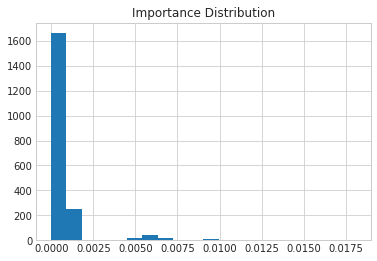

In [40]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [41]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [42]:
# ! pip install shapely

In [43]:
exp_stats_info

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v6_481_1,1382.0,1082,300,NaN,NaN,-0.061613,491,NaN,-1.0,NaN,NaN,54460.678832,2944.495810,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v6_481_2,1392.3,1190,300,BV_1.10,BV_1.11,3.179943,1255,BV_1.11,2.0,Lead,intersection_rearend,49806.079999,2001.306912,EG_17_23_1_0,rear_end,intersection,1.4210854715202004e-14,-0.429944,5.035916
2,ITE_autoware_universe_map_recalibrate_v6_481_3,1272.0,972,300,NaN,NaN,-0.147445,1801,NaN,-1.0,NaN,NaN,65145.572054,2173.005099,NaN,NaN,NaN,None,-10.000000,NaN
3,ITE_autoware_universe_map_recalibrate_v6_481_4,1338.0,1038,300,NaN,NaN,-0.092289,768,NaN,-1.0,NaN,NaN,57927.857197,1426.481520,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v6_481_5,1427.0,1127,300,NaN,NaN,-0.098064,912,NaN,-1.0,NaN,NaN,57357.766912,3850.465223,NaN,NaN,NaN,None,-10.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19418,ITE_autoware_universe_map_recalibrate_v6_295_37,1400.0,1100,300,NaN,NaN,-0.124026,1460,NaN,-1.0,NaN,NaN,67762.497684,2146.863968,NaN,NaN,NaN,None,-10.000000,NaN
19419,ITE_autoware_universe_map_recalibrate_v6_295_38,1421.0,1121,300,NaN,NaN,-0.319802,1378,NaN,-1.0,NaN,NaN,63208.835449,1706.337907,NaN,NaN,NaN,None,-10.000000,NaN
19420,ITE_autoware_universe_map_recalibrate_v6_295_39,1336.0,1036,300,NaN,NaN,-0.082162,659,NaN,-1.0,NaN,NaN,58829.724835,5024.966939,NaN,NaN,NaN,None,-10.000000,NaN
19421,ITE_autoware_universe_map_recalibrate_v6_295_40,1228.0,928,300,NaN,NaN,-0.102894,1068,NaN,-1.0,NaN,NaN,62494.216412,2400.751858,NaN,NaN,NaN,None,-10.000000,NaN


### Generate videos in the check list

In [44]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [45]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [46]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

  0%|          | 0/156 [00:01<?, ?it/s]

/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/ITE_autoware_universe_map_recalibrate_v6/raw_data/final_state/ITE_autoware_universe_map_recalibrate_v6_333_final_state.json


FileNotFoundError: [Errno 2] No such file or directory: './maps/Mcity/mcity.net.xml'

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()